# Comparison of haplotype frequency to eQTL associations

__Author:__ Bryan Quach  
__Date:__ May 23, 2017

### Estimated Analysis Time: <1 days

## Objective

Investigate whether the haplotype distributions across CC strains and/or genes in the eQTL hotspots are consistent.

## The Data

The data we start with are haplotype dosages (diplotype probabilities consolidated into haplotypes) at every genotype marker for every CC strain used in our control analysis. In our QTL analyses, adjacent markers are considered a single marker if they have the same maximum likelihood haplotype (the haplotype with the largest dosage/probability). In these cases, any consolidated markers have their dosages averaged for each haplotype. We will be working with these "merged" haplotype dosages. We also have text files containing chromosome sizes and mappings between marker names and genomic location.

For eQTL data, we have FDR controlled p-values that we filter to only associations with q-value <= 0.1. From this we further filter to q-values < 0.01 and calculate the number of associations with a given marker. FDR correction was performed on results of a cis + trans-eQTL analysis using the R package *qvalue*.

In [3]:
# Load general data
marker.map <- read.delim("data/marker_locations.txt", header=T, stringsAsFactors=F)
rownames(marker.map) <- marker.map$marker
marker.map <- marker.map[-1*which(marker.map$chromosome=="chrM"),] #Remove chrM
chr.sizes <- read.delim("data/mm9_chrom_sizes.txt", header=F, stringsAsFactors=F)
colnames(chr.sizes) <- c("chr","length")

# Convert chromosome lengths and genomic locations to Mb
chr.sizes$length <- chr.sizes$length/1000000
marker.map$position <- marker.map$position/1000000

In [23]:
# Load eQTLs
tmp.lung.eqtl <- readRDS("data//fdr_0.1_lung_trans.rds")
tmp.liver.eqtl <- readRDS("data//fdr_0.1_liver_trans.rds")
tmp.kidney.eqtl <- readRDS("data//fdr_0.1_kidney_trans.rds")
# Filter to FDR <= 0.01
tmp.lung.eqtl <- tmp.lung.eqtl[tmp.lung.eqtl$qval<=0.01,]
tmp.liver.eqtl <- tmp.liver.eqtl[tmp.liver.eqtl$qval<=0.01,]
tmp.kidney.eqtl <- tmp.kidney.eqtl[tmp.kidney.eqtl$qval<=0.01,]
lung.eqtl <- as.numeric(tmp.lung.eqtl$qval)
liver.eqtl <- as.numeric(tmp.liver.eqtl$qval)
kidney.eqtl <- as.numeric(tmp.kidney.eqtl$qval)
names(lung.eqtl) <- as.character(tmp.lung.eqtl$marker)
names(liver.eqtl) <- as.character(tmp.liver.eqtl$marker)
names(kidney.eqtl) <- as.character(tmp.kidney.eqtl$marker)

# Get new names for after division of merged markers into start and end markers
names.lung <- gsub(unlist(strsplit(names(lung.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
names.liver <- gsub(unlist(strsplit(names(liver.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
names.kidney <- gsub(unlist(strsplit(names(kidney.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
lung.eqtl <- rep(lung.eqtl, each=2)
liver.eqtl <- rep(liver.eqtl, each=2)
kidney.eqtl <- rep(kidney.eqtl, each=2)
names(lung.eqtl) <- names.lung
names(liver.eqtl) <- names.liver
names(kidney.eqtl) <- names.kidney

In [24]:
# Tabulate number of significant associations with each marker
count_associations <- function(marker, table){
    hits <- match(x=marker, table=names(table))
    if(is.na(hits)){
        return(0)
    }else if(length(hits)==1){
        return(as.numeric(table[hits]))
    }else{
        stop(paste("Multiple matches found for ", marker, sep=""))
    }
}
lung.table <- table(names(lung.eqtl))
liver.table <- table(names(liver.eqtl))
kidney.table <- table(names(kidney.eqtl))
lung.table <- lung.table[intersect(marker.map$marker, names(lung.table))] # Remove chrM
liver.table <- liver.table[intersect(marker.map$marker, names(liver.table))] # Remove chrM
kidney.table <- kidney.table[intersect(marker.map$marker, names(kidney.table))] # Remove chrM
lung.eqtl.counts <- sapply(marker.map$marker, count_associations, table=lung.table)
liver.eqtl.counts <- sapply(marker.map$marker, count_associations, table=liver.table)
kidney.eqtl.counts <- sapply(marker.map$marker, count_associations, table=kidney.table)
names(lung.eqtl.counts) <- marker.map$marker
names(liver.eqtl.counts) <- marker.map$marker
names(kidney.eqtl.counts) <- marker.map$marker
    
# Get genomic locations for each marker
lung.marker.position <- c(as.numeric(marker.map[names(lung.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(lung.eqtl.counts), "chromosome"], chr.sizes$chr)])
liver.marker.position <- c(as.numeric(marker.map[names(liver.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(liver.eqtl.counts), "chromosome"], chr.sizes$chr)])
kidney.marker.position <- c(as.numeric(marker.map[names(kidney.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(kidney.eqtl.counts), "chromosome"], chr.sizes$chr)])

# Order by genomic location
lung.eqtl.counts <- lung.eqtl.counts[order(lung.marker.position)]
liver.eqtl.counts <- liver.eqtl.counts[order(liver.marker.position)]
kidney.eqtl.counts <- kidney.eqtl.counts[order(kidney.marker.position)]
    
# Divide marker association counts by chromosome
lung.by.chr <- split(x=lung.eqtl.counts, f=marker.map[names(lung.eqtl.counts), "chromosome"][order(lung.marker.position)])
liver.by.chr <- split(x=liver.eqtl.counts, f=marker.map[names(liver.eqtl.counts), "chromosome"][order(liver.marker.position)])
kidney.by.chr <- split(x=kidney.eqtl.counts, f=marker.map[names(kidney.eqtl.counts), "chromosome"][order(kidney.marker.position)])
associations.by.chr <- list(lung=lung.by.chr, liver=liver.by.chr, kidney=kidney.by.chr)

lung.position.by.chr <- split(x=lung.marker.position[order(lung.marker.position)], f=marker.map[names(lung.eqtl.counts), "chromosome"][order(lung.marker.position)])
liver.position.by.chr <- split(x=liver.marker.position[order(liver.marker.position)], f=marker.map[names(liver.eqtl.counts), "chromosome"][order(liver.marker.position)])
kidney.position.by.chr <- split(x=kidney.marker.position[order(kidney.marker.position)], f=marker.map[names(kidney.eqtl.counts), "chromosome"][order(kidney.marker.position)])    
positions.by.chr <- list(lung=lung.position.by.chr, liver=liver.position.by.chr, kidney=kidney.position.by.chr)

## Summarize haplotype dosages as maximum likelihood haplotype frequencies

We summarize our haplotype data by calculating the frequency of a haplotype being the maximum likelihood haplotype across all strains at each marker. The maximum likelihood haplotype is simply the haplotype with the highest dosage value for a given strain at a given marker.

In [21]:
get.ml.haplo <- function(x,dosages){
    marker.haplotypes <- paste(x, LETTERS[1:8], sep="_")
    indices <- match(x=marker.haplotypes, table=colnames(dosages))
    if(length(indices)!=8){stop(paste("Missing haplotypes",length(indices),x))}
    ml.counts <- tabulate(unlist(apply(dosages[,indices], 1, function(x){which(x==max(x))})), nbins=8)
    names(ml.counts) <- marker.haplotypes
    return(ml.counts)
}
dosages <- readRDS("data/merged_haplotype_dosages.rds")
colnames(dosages) <- gsub(colnames(dosages), pattern="\\-", replacement="_") #Standardize marker names
merged.marker.names <- unique(gsub(names(dosages), pattern="_[A-H]$", replacement=""))
dosage.counts <- do.call("cbind", rep(lapply(merged.marker.names, get.ml.haplo, dosages),each=2))
colnames(dosage.counts) <- unlist(strsplit(merged.marker.names, split=".", fixed=T))
rownames(dosage.counts) <- LETTERS[1:8]
dosage.counts <- dosage.counts[,intersect(colnames(dosage.counts), marker.map$marker)] #Remove chrM
dosage.freq <- t(t(dosage.counts)/colSums(dosage.counts))
if(length(which(is.na(dosage.freq), arr.ind=T)[,2])>0){
    dosage.freq <- dosage.freq[,-1*which(is.na(dosage.freq), arr.ind=T)[,2]] #Remove markers with NAs
}

# Retrieve marker positions
marker.position <- c(as.numeric(marker.map[colnames(dosage.freq), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[colnames(dosage.freq), "chromosome"], chr.sizes$chr)])
marker.order <- order(marker.position)

# Divide haplotype frequencies by chromosome
haplo.chunks <- apply(dosage.freq[,marker.order], 1, function(x){split(x=x, f=marker.map[colnames(dosage.freq), "chromosome"][marker.order])})
position.chunks <- split(x=marker.position[marker.order], f=marker.map[colnames(dosage.freq), "chromosome"][marker.order])

## Plot haplotype frequencies and signficiant associations across the genome

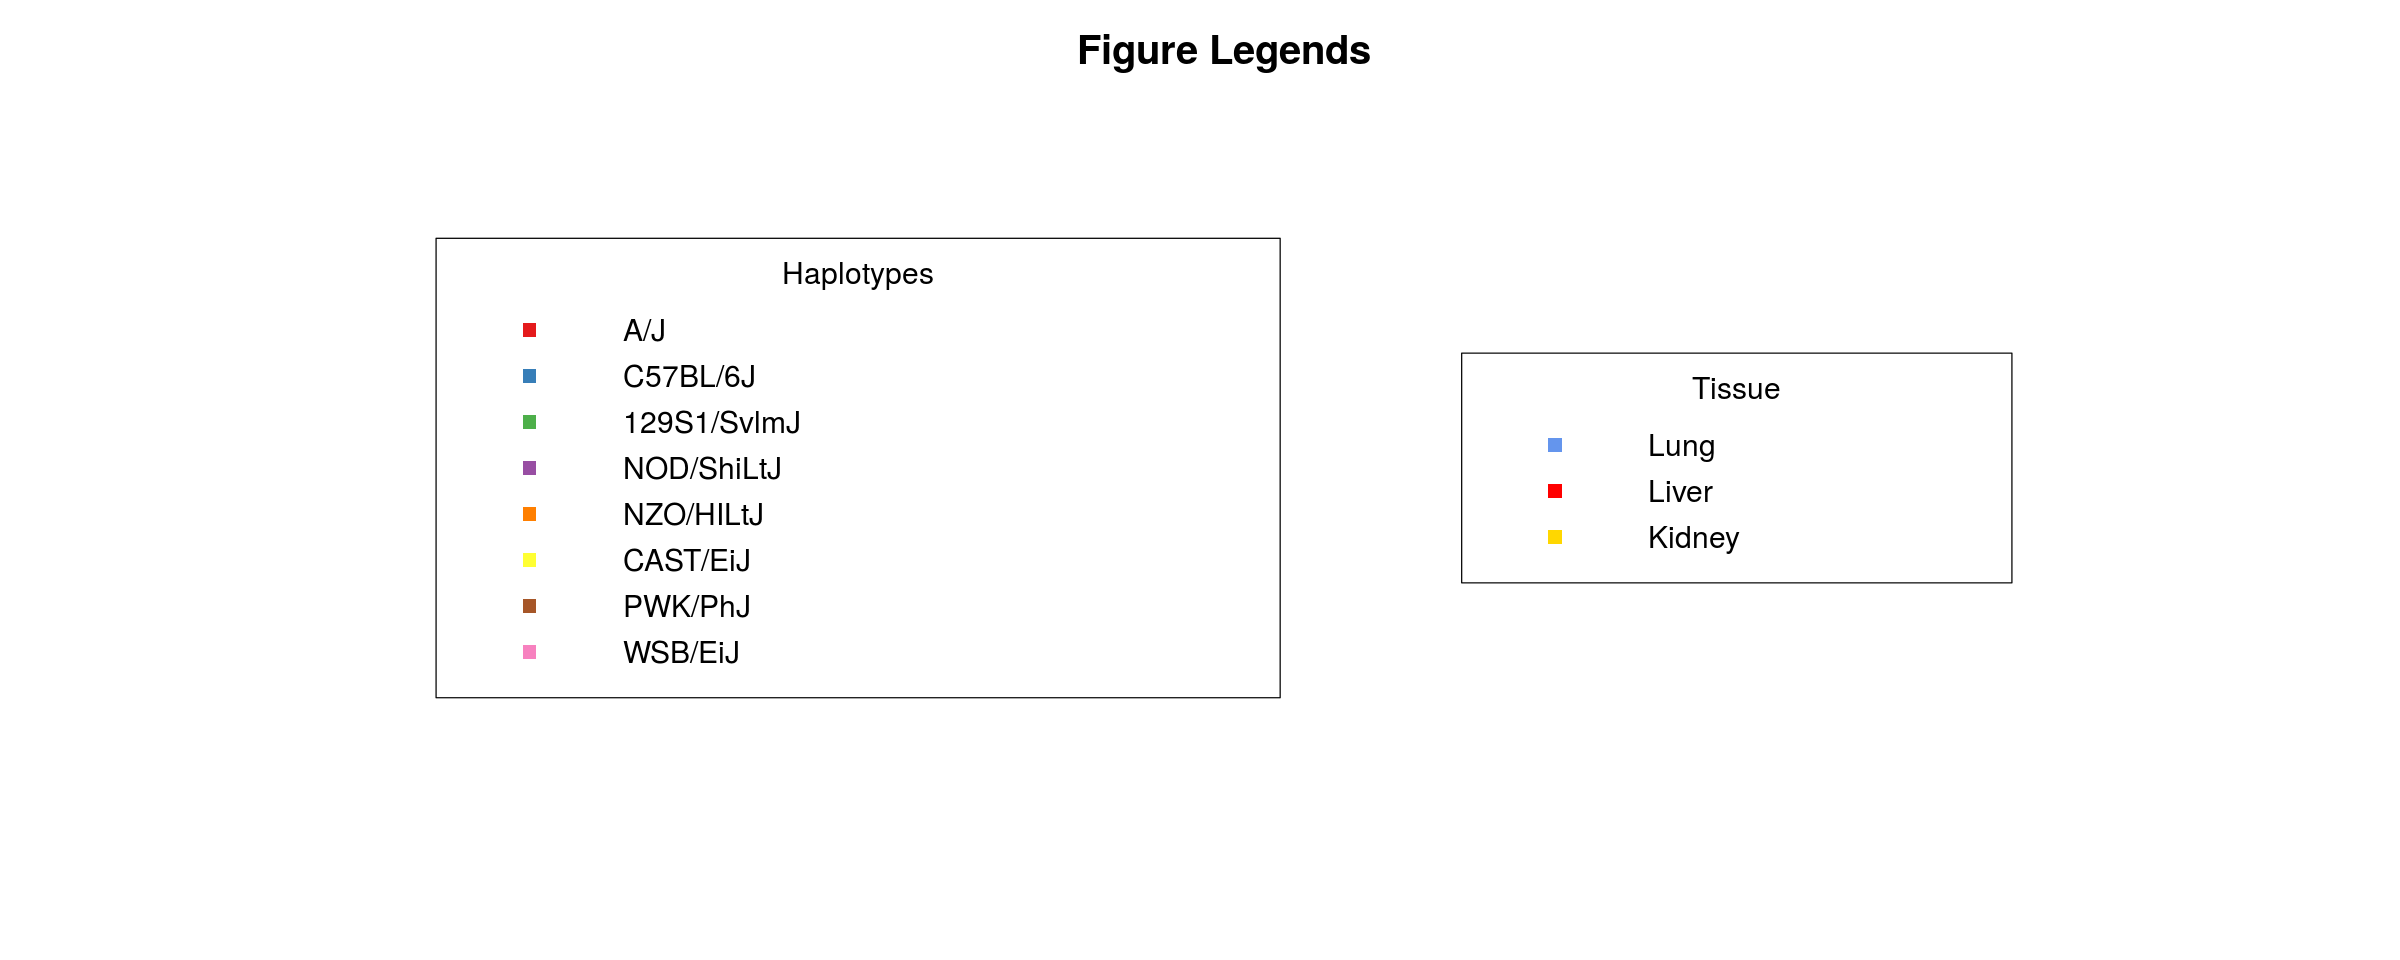

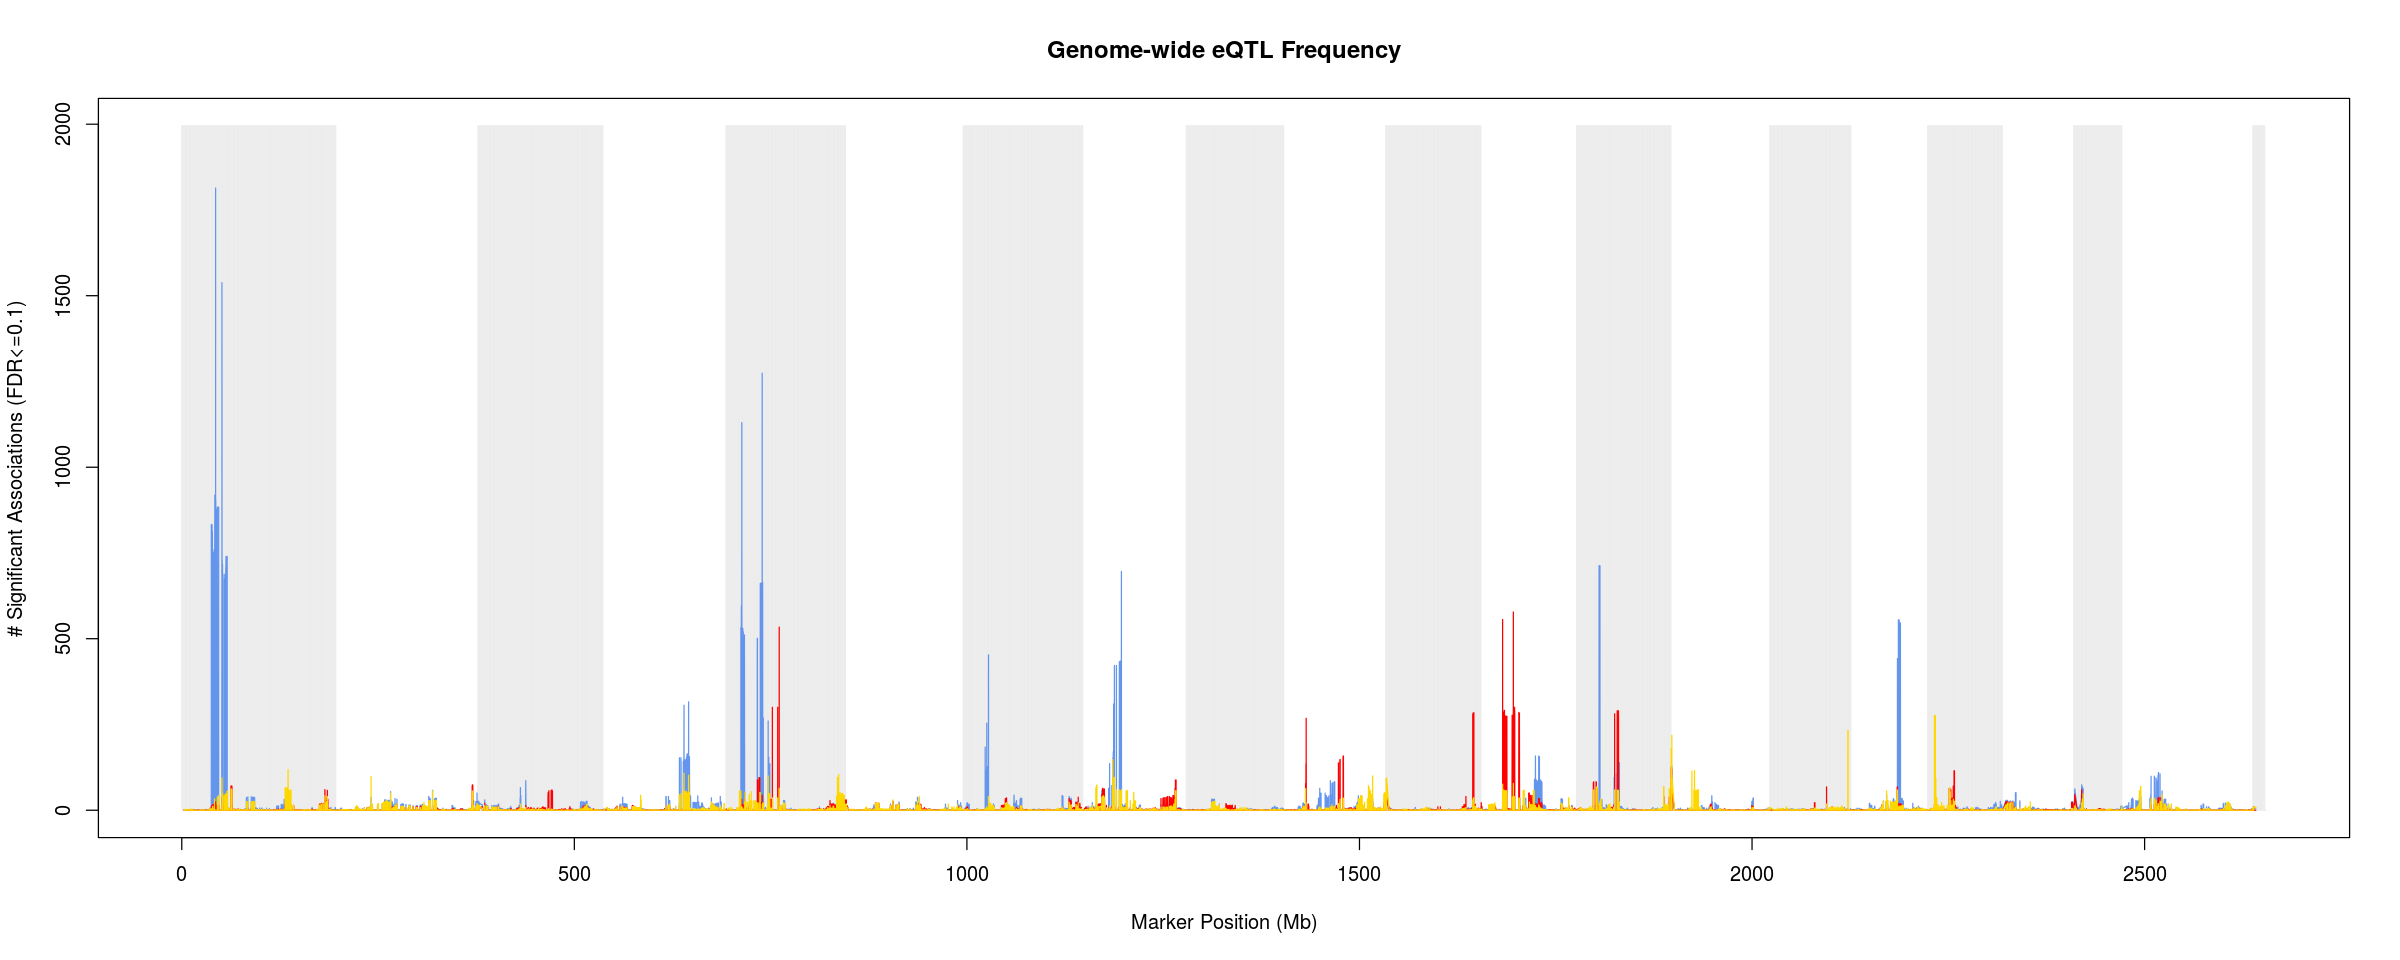

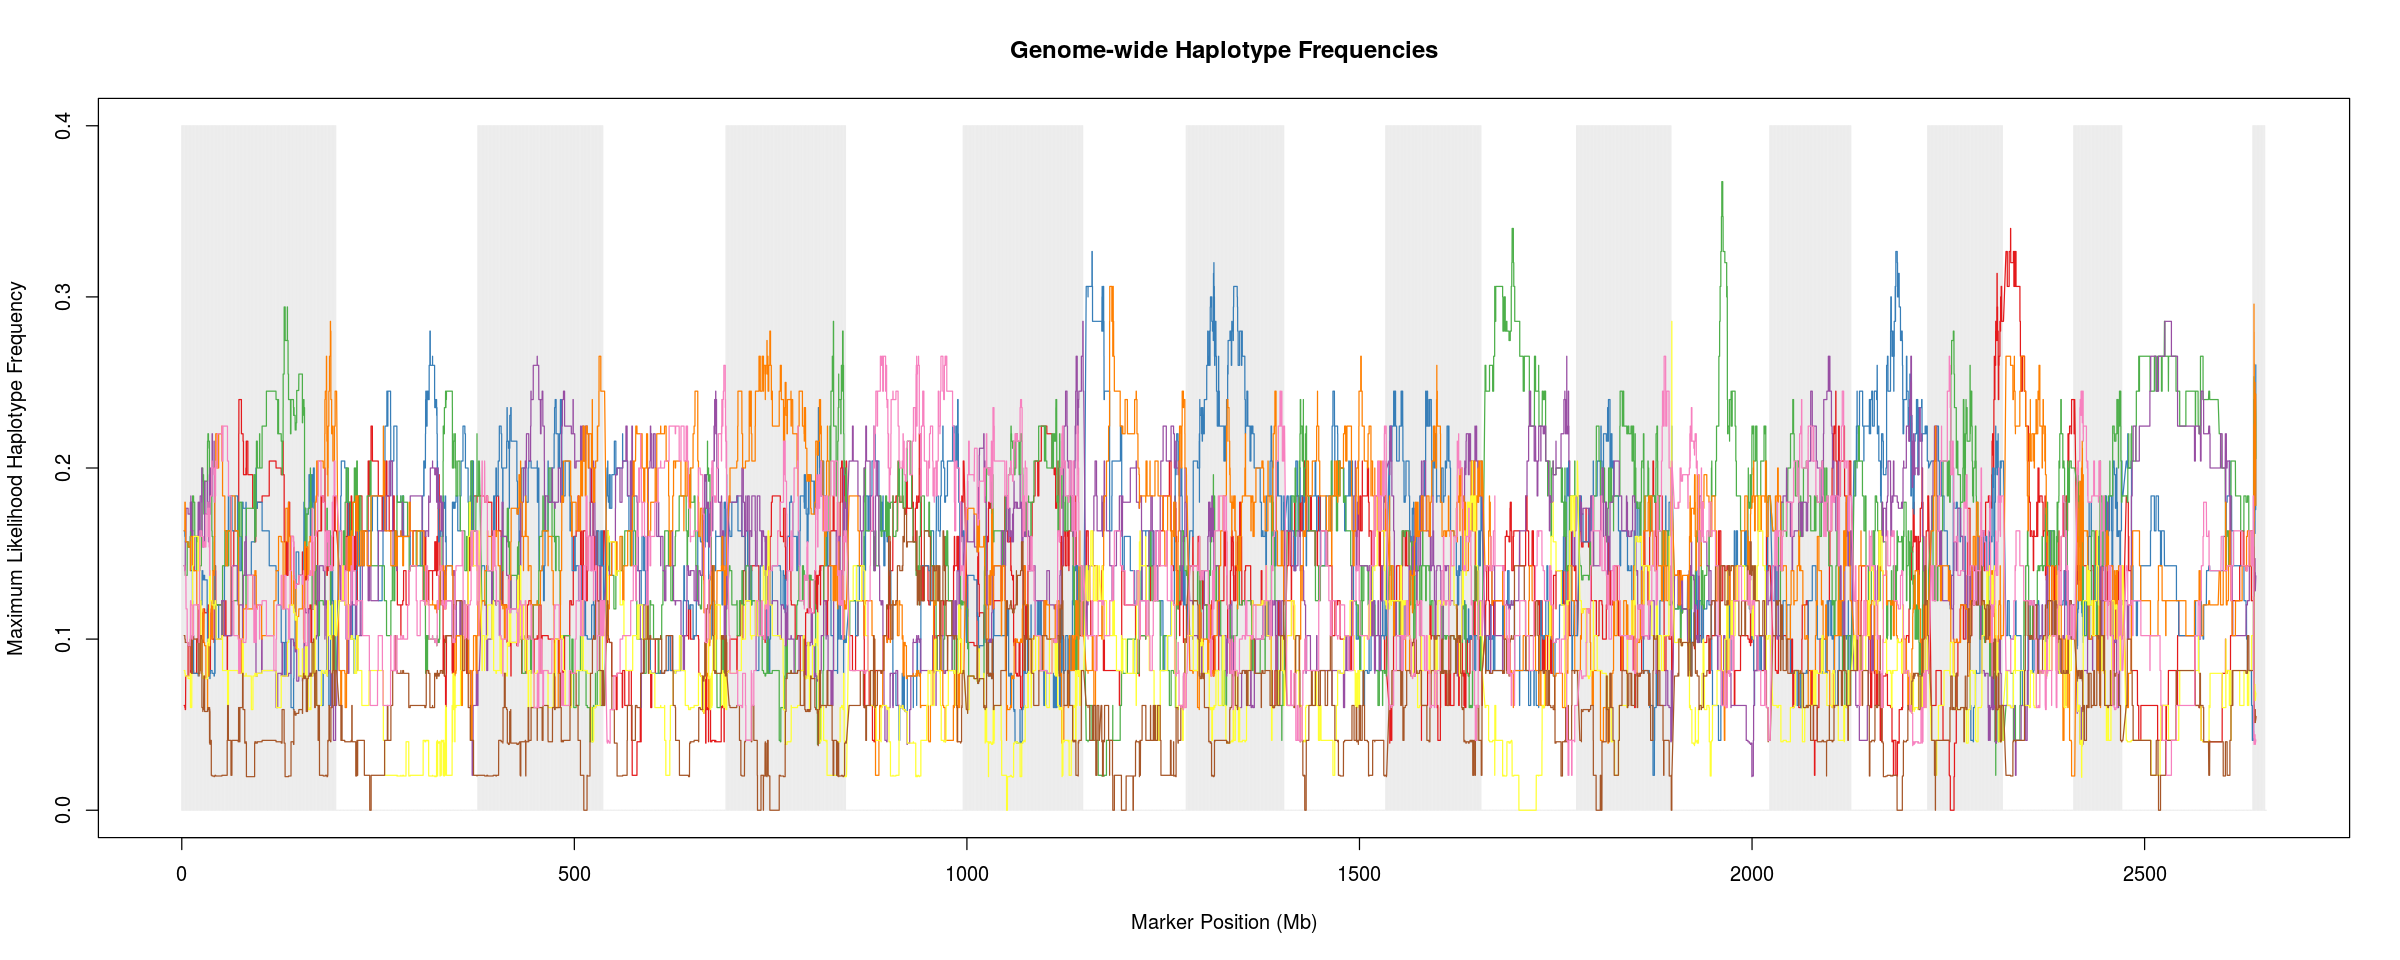

In [20]:
library(RColorBrewer)
options(repr.plot.width=20, repr.plot.height=8)

#Plot Legend
colors<-brewer.pal(8, "Set1")
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", xlab="", ylab="", main="Figure Legends", cex.main=2)
legend("left", pch=15, cex=1.5, col=colors, xpd=T, horiz=F, inset=c(0.15,0), title="Haplotypes",
       legend=c("A/J", "C57BL/6J", "129S1/SvlmJ", "NOD/ShiLtJ", "NZO/HILtJ", "CAST/EiJ", "PWK/PhJ", "WSB/EiJ"))
legend("right", pch=15, cex=1.5, col=c("cornflowerblue","red","gold"), xpd=T, horiz=F, inset=c(0.15,0), title="Tissue",
       legend=c("Lung","Liver","Kidney"))

## Signficant association plot
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot significant association frequencies
plot(x=lung.marker.position[order(lung.marker.position)], y=lung.eqtl.counts,
     ylim=range(c(lung.eqtl.counts, liver.eqtl.counts, kidney.eqtl.counts))*1.1,
     xlim=c(0,sum(chr.sizes$length)), xlab="Marker Position (Mb)", ylab="# Significant Associations (FDR<=0.1)", 
     main="Genome-wide eQTL Frequency", col="cornflowerblue", type="l", lwd=1)
points(x=liver.marker.position[order(liver.marker.position)], y=liver.eqtl.counts, type="l", lwd=1, col="red")
points(x=kidney.marker.position[order(kidney.marker.position)], y=kidney.eqtl.counts, type="l", lwd=1, col="gold")


## Haplotype plot
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot haplotype frequencies
plot(x=marker.position[marker.order], y=dosage.freq["A", marker.order], 
     xlim=c(0,sum(chr.sizes$length)), ylim=c(0,0.4), xlab="Marker Position (Mb)", ylab="Maximum Likelihood Haplotype Frequency", 
     main="Genome-wide Haplotype Frequencies", col=colors[1], type="l", lwd=1)
points(x=marker.position[marker.order], y=dosage.freq["B", marker.order], type="l", lwd=1, col=colors[2])
points(x=marker.position[marker.order], y=dosage.freq["C", marker.order], type="l", lwd=1, col=colors[3])
points(x=marker.position[marker.order], y=dosage.freq["D", marker.order], type="l", lwd=1, col=colors[4])
points(x=marker.position[marker.order], y=dosage.freq["E", marker.order], type="l", lwd=1, col=colors[5])
points(x=marker.position[marker.order], y=dosage.freq["F", marker.order], type="l", lwd=1, col=colors[6])
points(x=marker.position[marker.order], y=dosage.freq["G", marker.order], type="l", lwd=1, col=colors[7])
points(x=marker.position[marker.order], y=dosage.freq["H", marker.order], type="l", lwd=1, col=colors[8])


## Identify markers and genes in lung eQTL hotspot on chromosome 1

The number of significant associations in the hotspot on chr1 is >500 across all the markers, so we use that number to select for only markers in the hotspot.

In [25]:
# Create separate columns for start and end marker names
markers <- as.data.frame(do.call("rbind", sapply(as.character(tmp.lung.eqtl$marker), function(x){strsplit(x=x, split='.', fixed=T)})))
colnames(markers) <- c("marker.start", "marker.end")
markers$marker.start <- as.character(markers$marker.start)
markers$marker.end <- as.character(markers$marker.end)
tmp.lung.eqtl <- cbind(tmp.lung.eqtl, markers)[,-2]

# Get markers in hotspot region
hotspot.markers <- names(lung.by.chr$chr1[which(lung.by.chr$chr1>500)])
# Get sets of genes for each hotspot marker
hotspot.genes <- sapply(as.character(hotspot.markers), function(x){tmp.lung.eqtl$gene[which(as.character(tmp.lung.eqtl$marker.start)==x | as.character(tmp.lung.eqtl$marker.end)==x)]})

[1] "2310030G06Rik" "2700060E02Rik" "A930012L18Rik" "Abcc2"        
[5] "Acadsb"        "Acsl3"

In [32]:
#List core genes across hotspot markers
core.genes <- Reduce(f="intersect", x=hotspot.genes)
cat(core.genes, sep="\n")

2310030G06Rik
2700060E02Rik
A930012L18Rik
Abcc2
Acadsb
Acsl3
Adal
Adam9
Ago3
Ankrd49
Ap1s2
Ap3s1
Arhgef19
Arrdc3
Ascc3
Asxl2
Atad5
Atp11c
Bclaf1
Btbd1
Calm2
Caprin1
Card10
Ccdc47
Ccdc88a
Ccnc
Cdk8
Cib1
Clk4
Cops2
Cracr2b
Crebzf
Csnk1a1
Dcun1d1
Ddx19b
Dhx16
Dnajb6
Dnajc30
Dynlt3
Eea1
Eif2ak2
Eif2s3x
Emc2
Emsy
Eva1b
Fam149b
Fam175b
Fam193b
Fam195b
Fam76b
Fhod1
Gldc
Glipr1
Gm12191
Gm16386
Gm3414
Gng5
Gpcpd1
Gphn
Hdgfrp3
Ide
Ier2
Imp3
Inafm1
Irf2bp1
Klf2
Krcc1
Lamp2
Lancl2
Lgr4
Lin7c
Lrrc34
Man1c1
Man2c1os
Mapk9
Mblac2
Mcemp1
Med21
Megf6
Mir8104
Mrpl32
Nampt
Nckap5l
Ncor1
Nedd9
Nemf
Npdc1
Nt5dc1
Ofd1
Ogt
Osgepl1
Otud6b
Oxr1
Paip2
Parp9
Patz1
Pdha1
Pdhb
Pelp1
Pex13
Pex3
Pex5
Phf1
Phf11d
Pigh
Pigv
Pkn1
Plppr3
Pnisr
Ppp1r37
Ppt2
Prkx
Psip1
Psma3
Psmd1
Ptprd
Ptprj
Ptrf
Qrich1
Rad54b
Ranbp9
Rbck1
Rbmxl1
Ripply3
Rnf32
Rnf6
Rpp25l
Scrib
Sdhaf3
Sec62
Sema3a
Sept2
Serbp1
Set
Sfr1
Skiv2l2
Snora78
Snx10
Spag17
Srek1
Ssr3
Sucla2
Sumo2
Taf1d
Tank
Tarbp1
Tbc1d17
Tbcc
Tcaim
Tceb1
Thoc2
Thumpd3
Tmem167
Tm

In [33]:
#List union set of genes across hotspot markers
union.genes <- Reduce(f="union", x=hotspot.genes)
cat(union.genes, sep="\n")

0610010F05Rik
1110037F02Rik
1110059G10Rik
1810022K09Rik
2310030G06Rik
2700060E02Rik
2810410L24Rik
4930405O22Rik
8030462N17Rik
A830080D01Rik
A930012L18Rik
A930013F10Rik
AI597479
Aarsd1
Aatk
Abcb7
Abcc2
Abce1
Abhd18
Abi1
Abi2
Abl1
Acadsb
Acbd3
Acer3
Acsf3
Acsl3
Actr3
Actr5
Acvr2a
Adal
Adam9
Adat3
Ago3
Agps
Ajuba
Akap10
Akt3
Alg11
Ammecr1
Anapc10
Anapc2
Angptl3
Ankhd1
Ankrd17
Ankrd49
Ap1s2
Ap3m1
Ap3s1
Apc2
Api5
Arfgef1
Arhgap12
Arhgap5
Arhgef1
Arhgef19
Arl14ep
Arl5a
Arl8b
Armc5
Arrdc3
Ascc3
Asf1a
Ash1l
Asxl2
Atad1
Atad2
Atad5
Atf2
Atg101
Atg12
Atp11c
Atp6v0a1
Atr
Atxn3
Atxn7l3
B230354K17Rik
B3gnt2
B9d1
BC048403
Bahcc1
Baz2b
Bbip1
Bbx
Bcl7b
Bcl9l
Bclaf1
Bloc1s3
Blzf1
Bmpr1a
Brca1
Brca2
Brf1
Btaf1
Btbd1
Btf3l4
Btg3
Bzw1
C1galt1c1
C1qtnf7
C230091D08Rik
C77080
Cab39
Calm1
Calm2
Camta2
Caprin1
Card10
Casc3
Casp8ap2
Cbx4
Cbx8
Ccdc25
Ccdc47
Ccdc58
Ccdc88a
Ccdc9
Ccnb2
Ccnc
Ccnt2
Ccser2
Cd2ap
Cd86
Cdc27
Cdc37l1
Cdc42bpb
Cdipt
Cdk12
Cdk18
Cdk8
Cdkl1
Cenpf
Cep170
Cep295
Cept1
Chkb
Chm
Chml
Chn2
Cib1